In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from shutil import rmtree
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm, trange
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.datasets import ImageFolder

from predictors.alexnet import Alexnet
from predictors.half_alexnet import HalfAlexnet

from datasets import CIFAR10, ProxyDataset

%matplotlib inline

In [3]:
LR = 0.001
EPOCHS = 200
BATCH_SIZE = 32
CONFIDENCE_TH = 0.8

DATASET_PATH = '.'
TEMP_BEST_MODEL = 'cosine_imagespace_experiments'

# Set random seed for replicating testing results
RANDOM_SEED = 0
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Teacher
teacher_model = Alexnet(name=None, n_outputs=10)

ckpt_path = 'checkpoints/teacher_alexnet_for_cifar10_state_dict'
teacher_model.load_state_dict(torch.load(ckpt_path, map_location=device))
teacher_model.eval()
teacher_model = teacher_model.to(device)

In [5]:
# Define dataset
label_mapper = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}
label_mapper_inv = {v:k for k,v in label_mapper.items()}

# Get images paths and labels
images = []
labels = []

folders_path = os.path.join(DATASET_PATH,'images_generated')
for folder in os.listdir(folders_path):
    if 'imagenet' in folder:
      continue
    class_path = os.path.join(folders_path,folder)
    images_names = os.listdir(class_path)
    
    for image_name in images_names:
        images.append(os.path.join(class_path,image_name))
        labels.append(label_mapper[folder])

In [6]:
proxy_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

proxy_dataset = ProxyDataset(images, labels, proxy_transforms, True)
proxy_dataloader  = DataLoader(proxy_dataset,  batch_size=BATCH_SIZE)

# Obtain teacher predictions
filtered_images = []
filtered_labels = []
filtered_soft_labels = []

with torch.no_grad():
    for img,label,path,_ in tqdm(proxy_dataloader):
        img = img.to(device=device)
        label = label.to(device=device)

        logits = teacher_model(img)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)

        filtered_images.extend(list(path))
        filtered_labels.extend(y_hat.tolist())
        filtered_soft_labels.extend(pred)
        
# Display results of filtering
print(f'A total of {len(filtered_images)} remained out of {len(proxy_dataset)}')
print()
counter_per_class = {v:0 for k,v in label_mapper.items()}
for label in filtered_labels:
    counter_per_class[label] += 1
for clasa in counter_per_class:
    print(f'Class {clasa}({label_mapper_inv[clasa]}) has {counter_per_class[clasa]} entries')

  0%|          | 0/1600 [00:00<?, ?it/s]

A total of 51200 remained out of 51200

Class 0(airplane) has 6384 entries
Class 1(automobile) has 5145 entries
Class 2(bird) has 4795 entries
Class 3(cat) has 5331 entries
Class 4(deer) has 5571 entries
Class 5(dog) has 4286 entries
Class 6(frog) has 4553 entries
Class 7(horse) has 5025 entries
Class 8(ship) has 5178 entries
Class 9(truck) has 4932 entries


In [7]:
# Define the student model
student_model = HalfAlexnet(name=None, n_outputs=10)

path_to_save = 'pretrained_student.pt'
if torch.cuda.is_available():
    student_model.load_state_dict(torch.load(path_to_save))
else:
    student_model.load_state_dict(torch.load(path_to_save, map_location ='cpu'))
student_model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=LR)

# Define loss function
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

In [8]:
try:
  # raise
  # Do a stratified split of the data
  NO_IMGS_TO_USE = 32768
  
  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
      train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels, random_state=RANDOM_SEED)  

  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
      train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=0.8, stratify=filtered_labels_subset, random_state=RANDOM_SEED)
  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels, random_state=RANDOM_SEED)
except:
  # For small datasets 
  print('Small dataset')
  NO_IMGS_TO_USE = 60
  NO_TRAIN_IMGS = 40

  """ DEV - train_test_split fails, need to manually introduce 1 sample
  """
  for i in range(len(filtered_labels)-1,-1,-1):
    if filtered_labels[i] == 5:
      img_dev = filtered_images[i]
      soft_label_dev = filtered_soft_labels[i]
      break

  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
    train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels, random_state=RANDOM_SEED)  
  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
    train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=NO_TRAIN_IMGS, stratify=filtered_labels_subset, random_state=RANDOM_SEED)
  
  """ DEV - interchange an image
  """
  for i in range(len(validation_images)):
    if validation_labels[i] == 0:
      validation_images[i] = img_dev
      validation_labels[i] = 5
      validation_soft_labels[i] = soft_label_dev
      break

  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)

In [9]:
# Define the transformations
train_transforms = T.Compose([
    T.Resize((32,32)),
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize((0.5,), (0.5,))
])
valid_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

# Define the proxy datasets
proxy_train_dataset = ProxyDataset(train_images, train_labels, train_transforms, False, train_soft_labels)
proxy_valid_dataset = ProxyDataset(valid_images, valid_labels, valid_transforms, False, valid_soft_labels)
proxy_test_dataset  = ProxyDataset(test_images,  test_labels,  valid_transforms, False, test_soft_labels)

# Define the proxy dataloaders
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(proxy_valid_dataset, batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(proxy_test_dataset,  batch_size=BATCH_SIZE)

# Define true dataset
true_dataset = CIFAR10(input_size = 32)

validate_on_trueds = True
if validate_on_trueds:
    true_valid_ds = true_dataset.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Class for early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.min_valid_loss = np.inf
        self.early_stop = False

    def __call__(self, validation_loss):
        if validation_loss < self.min_valid_loss:
          self.min_valid_loss = validation_loss
          self.counter = 0
        elif validation_loss > self.min_valid_loss + self.min_delta:
          self.counter +=1
          
          if self.counter >= self.tolerance:  
              self.early_stop = True

In [11]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.05)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

best_accuracy = 0.0
# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    # Save best model
    valid_proxy_acc = acc/len(proxy_valid_dataset)
    if valid_proxy_acc > best_accuracy:
        best_accuracy = valid_proxy_acc
        torch.save(student_model.state_dict(), f'temp_models/{TEMP_BEST_MODEL}.pt')
        print(f'Saved at epoch {epoch}')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

        
    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

student_model.load_state_dict(torch.load(f'temp_models/{TEMP_BEST_MODEL}.pt'))

  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5477
validation_accuracy on proxy = 83.22%
Saved at epoch 0
validation_loss on true ds = 1.3466
validation_accuracy on true ds = 53.13%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5379
validation_accuracy on proxy = 83.95%
Saved at epoch 1
validation_loss on true ds = 1.4322
validation_accuracy on true ds = 52.70%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4959
validation_accuracy on proxy = 84.93%
Saved at epoch 2
validation_loss on true ds = 1.2455
validation_accuracy on true ds = 56.92%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4953
validation_accuracy on proxy = 85.14%
Saved at epoch 3
validation_loss on true ds = 1.2372
validation_accuracy on true ds = 57.42%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4853
validation_accuracy on proxy = 85.23%
Saved at epoch 4
validation_loss on true ds = 1.1187
validation_accuracy on true ds = 61.13%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5089
validation_accuracy on proxy = 85.32%
Saved at epoch 5
validation_loss on true ds = 1.2482
validation_accuracy on true ds = 58.78%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4756
validation_accuracy on proxy = 85.60%
Saved at epoch 6
validation_loss on true ds = 1.0728
validation_accuracy on true ds = 62.46%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4660
validation_accuracy on proxy = 86.36%
Saved at epoch 7
validation_loss on true ds = 1.0722
validation_accuracy on true ds = 62.86%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4495
validation_accuracy on proxy = 86.54%
Saved at epoch 8
validation_loss on true ds = 1.0697
validation_accuracy on true ds = 63.15%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4744
validation_accuracy on proxy = 85.99%
validation_loss on true ds = 1.1285
validation_accuracy on true ds = 61.85%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4795
validation_accuracy on proxy = 85.84%
validation_loss on true ds = 1.0972
validation_accuracy on true ds = 62.22%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4634
validation_accuracy on proxy = 85.78%
validation_loss on true ds = 1.1061
validation_accuracy on true ds = 62.58%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4468
validation_accuracy on proxy = 85.93%
validation_loss on true ds = 1.0097
validation_accuracy on true ds = 64.97%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4441
validation_accuracy on proxy = 86.33%
validation_loss on true ds = 0.9950
validation_accuracy on true ds = 65.88%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4558
validation_accuracy on proxy = 86.30%
validation_loss on true ds = 0.9750
validation_accuracy on true ds = 66.70%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4394
validation_accuracy on proxy = 86.82%
Saved at epoch 15
validation_loss on true ds = 1.0959
validation_accuracy on true ds = 62.87%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4575
validation_accuracy on proxy = 86.36%
validation_loss on true ds = 0.9918
validation_accuracy on true ds = 66.33%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4293
validation_accuracy on proxy = 86.60%
validation_loss on true ds = 0.9745
validation_accuracy on true ds = 66.28%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4348
validation_accuracy on proxy = 86.60%
validation_loss on true ds = 0.9598
validation_accuracy on true ds = 66.89%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4366
validation_accuracy on proxy = 86.08%
validation_loss on true ds = 0.9645
validation_accuracy on true ds = 66.65%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4227
validation_accuracy on proxy = 87.00%
Saved at epoch 20
validation_loss on true ds = 0.9500
validation_accuracy on true ds = 66.82%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4437
validation_accuracy on proxy = 86.79%
validation_loss on true ds = 1.0229
validation_accuracy on true ds = 65.07%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4258
validation_accuracy on proxy = 86.48%
validation_loss on true ds = 0.9471
validation_accuracy on true ds = 67.46%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4492
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9844
validation_accuracy on true ds = 66.71%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4452
validation_accuracy on proxy = 86.24%
validation_loss on true ds = 0.9649
validation_accuracy on true ds = 67.02%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4465
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9356
validation_accuracy on true ds = 67.50%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4328
validation_accuracy on proxy = 86.85%
validation_loss on true ds = 0.9488
validation_accuracy on true ds = 68.01%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4334
validation_accuracy on proxy = 86.45%
validation_loss on true ds = 0.9477
validation_accuracy on true ds = 67.19%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4502
validation_accuracy on proxy = 86.12%
validation_loss on true ds = 0.9721
validation_accuracy on true ds = 66.97%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4362
validation_accuracy on proxy = 86.79%
validation_loss on true ds = 0.9570
validation_accuracy on true ds = 67.55%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4534
validation_accuracy on proxy = 86.63%
validation_loss on true ds = 0.9612
validation_accuracy on true ds = 67.62%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4267
validation_accuracy on proxy = 87.03%
Saved at epoch 31
validation_loss on true ds = 0.9401
validation_accuracy on true ds = 68.48%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4418
validation_accuracy on proxy = 86.60%
validation_loss on true ds = 0.9360
validation_accuracy on true ds = 68.90%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4356
validation_accuracy on proxy = 87.09%
Saved at epoch 33
validation_loss on true ds = 0.9236
validation_accuracy on true ds = 68.19%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4446
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9071
validation_accuracy on true ds = 69.82%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4375
validation_accuracy on proxy = 87.00%
validation_loss on true ds = 0.9576
validation_accuracy on true ds = 67.92%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4364
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9057
validation_accuracy on true ds = 69.81%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4463
validation_accuracy on proxy = 86.45%
validation_loss on true ds = 0.9045
validation_accuracy on true ds = 70.14%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4514
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9678
validation_accuracy on true ds = 67.40%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4408
validation_accuracy on proxy = 86.60%
validation_loss on true ds = 0.9694
validation_accuracy on true ds = 67.36%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4406
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9650
validation_accuracy on true ds = 67.03%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4344
validation_accuracy on proxy = 86.51%
validation_loss on true ds = 0.9206
validation_accuracy on true ds = 69.42%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4497
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9085
validation_accuracy on true ds = 69.82%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4435
validation_accuracy on proxy = 86.39%
validation_loss on true ds = 0.9813
validation_accuracy on true ds = 68.14%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4489
validation_accuracy on proxy = 86.33%
validation_loss on true ds = 0.9160
validation_accuracy on true ds = 69.58%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4281
validation_accuracy on proxy = 87.00%
validation_loss on true ds = 0.9156
validation_accuracy on true ds = 69.23%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4441
validation_accuracy on proxy = 86.48%
validation_loss on true ds = 0.9290
validation_accuracy on true ds = 69.12%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4336
validation_accuracy on proxy = 86.91%
validation_loss on true ds = 0.9351
validation_accuracy on true ds = 68.57%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4405
validation_accuracy on proxy = 86.79%
validation_loss on true ds = 0.9546
validation_accuracy on true ds = 68.79%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4314
validation_accuracy on proxy = 86.66%
validation_loss on true ds = 0.9355
validation_accuracy on true ds = 68.93%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4549
validation_accuracy on proxy = 86.45%
validation_loss on true ds = 0.9495
validation_accuracy on true ds = 68.39%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4451
validation_accuracy on proxy = 86.42%
validation_loss on true ds = 0.9132
validation_accuracy on true ds = 69.34%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4476
validation_accuracy on proxy = 86.51%
validation_loss on true ds = 0.9127
validation_accuracy on true ds = 69.50%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4322
validation_accuracy on proxy = 86.97%
validation_loss on true ds = 0.9206
validation_accuracy on true ds = 69.31%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4439
validation_accuracy on proxy = 86.79%
validation_loss on true ds = 0.9096
validation_accuracy on true ds = 69.79%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4548
validation_accuracy on proxy = 86.18%
validation_loss on true ds = 0.9626
validation_accuracy on true ds = 68.44%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4586
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9714
validation_accuracy on true ds = 67.99%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4548
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9203
validation_accuracy on true ds = 69.22%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4495
validation_accuracy on proxy = 86.12%
validation_loss on true ds = 0.9675
validation_accuracy on true ds = 68.55%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4500
validation_accuracy on proxy = 86.66%
validation_loss on true ds = 0.9296
validation_accuracy on true ds = 69.51%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4546
validation_accuracy on proxy = 86.91%
validation_loss on true ds = 0.9667
validation_accuracy on true ds = 69.05%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4570
validation_accuracy on proxy = 86.57%
validation_loss on true ds = 0.9186
validation_accuracy on true ds = 69.82%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4589
validation_accuracy on proxy = 86.66%
validation_loss on true ds = 0.9309
validation_accuracy on true ds = 69.46%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4576
validation_accuracy on proxy = 86.91%
validation_loss on true ds = 0.9220
validation_accuracy on true ds = 69.43%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4660
validation_accuracy on proxy = 86.08%
validation_loss on true ds = 1.0159
validation_accuracy on true ds = 67.43%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4639
validation_accuracy on proxy = 87.09%
validation_loss on true ds = 0.9931
validation_accuracy on true ds = 67.69%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4555
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9625
validation_accuracy on true ds = 68.26%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4545
validation_accuracy on proxy = 86.39%
validation_loss on true ds = 0.9435
validation_accuracy on true ds = 68.98%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4503
validation_accuracy on proxy = 86.97%
validation_loss on true ds = 0.9334
validation_accuracy on true ds = 69.39%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4613
validation_accuracy on proxy = 86.33%
validation_loss on true ds = 0.9128
validation_accuracy on true ds = 70.13%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4656
validation_accuracy on proxy = 86.42%
validation_loss on true ds = 0.9372
validation_accuracy on true ds = 69.20%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4679
validation_accuracy on proxy = 86.48%
validation_loss on true ds = 0.9334
validation_accuracy on true ds = 69.19%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4625
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9257
validation_accuracy on true ds = 70.30%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4824
validation_accuracy on proxy = 87.12%
Saved at epoch 73
validation_loss on true ds = 0.9402
validation_accuracy on true ds = 70.01%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4517
validation_accuracy on proxy = 87.03%
validation_loss on true ds = 0.9174
validation_accuracy on true ds = 70.36%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4522
validation_accuracy on proxy = 87.18%
Saved at epoch 75
validation_loss on true ds = 0.9771
validation_accuracy on true ds = 67.70%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4478
validation_accuracy on proxy = 86.48%
validation_loss on true ds = 0.9266
validation_accuracy on true ds = 69.87%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4643
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9609
validation_accuracy on true ds = 69.49%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4578
validation_accuracy on proxy = 86.66%
validation_loss on true ds = 1.0015
validation_accuracy on true ds = 68.07%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4576
validation_accuracy on proxy = 87.00%
validation_loss on true ds = 0.9271
validation_accuracy on true ds = 69.84%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4596
validation_accuracy on proxy = 86.73%
validation_loss on true ds = 0.9398
validation_accuracy on true ds = 69.79%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4753
validation_accuracy on proxy = 85.75%
validation_loss on true ds = 0.9620
validation_accuracy on true ds = 69.59%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4630
validation_accuracy on proxy = 86.70%
validation_loss on true ds = 0.9612
validation_accuracy on true ds = 69.01%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4689
validation_accuracy on proxy = 86.57%
validation_loss on true ds = 0.9713
validation_accuracy on true ds = 68.86%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4602
validation_accuracy on proxy = 87.09%
validation_loss on true ds = 0.8886
validation_accuracy on true ds = 70.57%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4605
validation_accuracy on proxy = 87.15%
validation_loss on true ds = 0.9398
validation_accuracy on true ds = 69.65%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4550
validation_accuracy on proxy = 86.51%
validation_loss on true ds = 0.9690
validation_accuracy on true ds = 69.34%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4586
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9070
validation_accuracy on true ds = 70.33%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4613
validation_accuracy on proxy = 86.70%
validation_loss on true ds = 0.9343
validation_accuracy on true ds = 70.00%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4708
validation_accuracy on proxy = 86.45%
validation_loss on true ds = 1.0382
validation_accuracy on true ds = 67.31%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4680
validation_accuracy on proxy = 86.30%
validation_loss on true ds = 0.9526
validation_accuracy on true ds = 69.46%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4528
validation_accuracy on proxy = 86.94%
validation_loss on true ds = 0.9171
validation_accuracy on true ds = 70.01%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4454
validation_accuracy on proxy = 86.70%
validation_loss on true ds = 0.9266
validation_accuracy on true ds = 69.88%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4657
validation_accuracy on proxy = 86.79%
validation_loss on true ds = 0.9289
validation_accuracy on true ds = 69.88%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4777
validation_accuracy on proxy = 86.27%
validation_loss on true ds = 0.9758
validation_accuracy on true ds = 68.91%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4603
validation_accuracy on proxy = 86.45%
validation_loss on true ds = 0.9255
validation_accuracy on true ds = 70.66%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4709
validation_accuracy on proxy = 87.18%
validation_loss on true ds = 0.9306
validation_accuracy on true ds = 69.95%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4630
validation_accuracy on proxy = 86.42%
validation_loss on true ds = 0.9896
validation_accuracy on true ds = 68.24%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4593
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9707
validation_accuracy on true ds = 68.66%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4792
validation_accuracy on proxy = 85.32%
validation_loss on true ds = 1.0519
validation_accuracy on true ds = 67.45%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4626
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9287
validation_accuracy on true ds = 70.17%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4797
validation_accuracy on proxy = 85.84%
validation_loss on true ds = 0.9744
validation_accuracy on true ds = 68.50%
We are at epoch 101


<All keys matched successfully>

In [12]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
student_model.return_feature_domain = False
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            if a == p:
                acc_per_class[a][0] += 1 # correct predictions
            acc_per_class[a][1] += 1     # total number 
            acc_per_class[p][2] += 1     # predictions of class
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: correct_pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 0.9771
test_accuracy = 67.70%

Class airplane: correct_pred=645, actual=1000 => acc=64.50%, total_pred=849
Class automobile: correct_pred=719, actual=1000 => acc=71.90%, total_pred=787
Class bird: correct_pred=545, actual=1000 => acc=54.50%, total_pred=826
Class cat: correct_pred=742, actual=1000 => acc=74.20%, total_pred=1886
Class deer: correct_pred=554, actual=1000 => acc=55.40%, total_pred=743
Class dog: correct_pred=633, actual=1000 => acc=63.30%, total_pred=1070
Class frog: correct_pred=629, actual=1000 => acc=62.90%, total_pred=755
Class horse: correct_pred=721, actual=1000 => acc=72.10%, total_pred=1037
Class ship: correct_pred=774, actual=1000 => acc=77.40%, total_pred=994
Class truck: correct_pred=808, actual=1000 => acc=80.80%, total_pred=1053


In [13]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            if a == p:
                acc_per_class[a][0] += 1
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: correct_pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 0.9482
test_accuracy = 68.14%

Class airplane: correct_pred=667, actual=1038 => acc=64.26%, total_pred=849
Class automobile: correct_pred=726, actual=1002 => acc=72.46%, total_pred=787
Class bird: correct_pred=550, actual=965 => acc=56.99%, total_pred=826
Class cat: correct_pred=719, actual=938 => acc=76.65%, total_pred=1886
Class deer: correct_pred=573, actual=1108 => acc=51.71%, total_pred=743
Class dog: correct_pred=614, actual=913 => acc=67.25%, total_pred=1070
Class frog: correct_pred=637, actual=996 => acc=63.96%, total_pred=755
Class horse: correct_pred=748, actual=1063 => acc=70.37%, total_pred=1037
Class ship: correct_pred=751, actual=939 => acc=79.98%, total_pred=994
Class truck: correct_pred=829, actual=1038 => acc=79.87%, total_pred=1053


In [14]:
# Redefine training dataset and dataloader with no augmentation
db_dataset_temp = ProxyDataset(train_images, train_labels, valid_transforms, False, train_soft_labels)
images_db = []
labels_db = []
for i in range(len(db_dataset_temp)):
    img, _, s_lbl = db_dataset_temp[i]
    images_db.append(img)
    labels_db.append(s_lbl)

class DBDataset(Dataset):
  def __init__(self, images_db, labels_db):
    self.images_db = images_db
    self.labels_db = labels_db

  def __len__(self):
    return len(self.images_db)

  def __getitem__(self, idx):
    image = self.images_db[idx]
    label = self.labels_db[idx]

    return image, label

db_dataset = DBDataset(images_db=images_db, labels_db=labels_db)
db_dataloader = DataLoader(db_dataset, batch_size=128, shuffle=False)

proxy_unused_dataset  = ProxyDataset(filtered_images_unused,  filtered_labels_unused,  valid_transforms, True, filtered_soft_labels_unused)

In [15]:
k = 3
estimations = []
ground_truth = []

for i in trange(len(proxy_unused_dataset)):
  image, label, image_path, soft_label = proxy_unused_dataset[i]
  image = image.to(device=device).unsqueeze(dim=0)

  norm_unkwn = torch.sqrt(torch.sum(torch.square(image), dim=(-1,-2,-3), keepdim=True))

  # Calculate distances
  distances = torch.zeros(size=(len(db_dataset),), device=device)
  for j, (img_db, _) in enumerate(db_dataloader):
    img_db = img_db.to(device=device)
    
    norm_db = torch.sqrt(torch.sum(torch.square(img_db), dim=(-1,-2,-3), keepdim=True))

    dot_prod = torch.tensordot(img_db, image, dims=[[-1,-2,-3],[-1,-2,-3]])
    denominator = (norm_db * norm_unkwn).squeeze(dim=-1).squeeze(dim=-1)
    cosine_similarities = (dot_prod / denominator).squeeze(dim=-1)
    
    distances[j*128:(j+1)*128] = cosine_similarities
    
  smallest_d, smallest_d_indices = torch.topk(distances, k=k, largest=True)
  closest_slabels = torch.vstack([db_dataset[l][1] for l in smallest_d_indices])
  
  estimated_soft_label = closest_slabels.mean(0)
  estimated_hard_label = estimated_soft_label.argmax().item()
  
  # print(f'Ground truth soft_label = {soft_label}')
  # print(f'Estimated soft_label = {estimated_soft_label}')
  # print(f'Ground truth hard_label = {label}')
  # print(f'Estimated hard_label = {estimated_hard_label}')
  
  # print(f'Smallest 3 distances: {smallest_d}')
  # print(f'Smallest 3 indices: {smallest_d_indices}')
  # print(f'Closest 3 slabels = {closest_slabels}')
  
  train_images.append(image_path)
  train_labels.append(estimated_hard_label)
  train_soft_labels.append(estimated_soft_label)

  estimations.append(estimated_hard_label)
  ground_truth.append(label)

correct = (np.array(estimations) == np.array(ground_truth)).sum()
print(f'Final score for k={k}: {correct} / {len(estimations)}, acc = {correct/len(estimations)}')

  0%|          | 0/18432 [00:00<?, ?it/s]

Final score for k=3: 11737 / 18432, acc = 0.6367730034722222


In [16]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.05)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

best_accuracy = 0.0
# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    # Save best model
    valid_proxy_acc = acc/len(proxy_valid_dataset)
    if valid_proxy_acc > best_accuracy:
        best_accuracy = valid_proxy_acc
        torch.save(student_model.state_dict(), f'temp_models/{TEMP_BEST_MODEL}.pt')
        print(f'Saved at epoch {epoch}')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

        
    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

student_model.load_state_dict(torch.load(f'temp_models/{TEMP_BEST_MODEL}.pt'))

  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5018
validation_accuracy on proxy = 86.45%
Saved at epoch 0
validation_loss on true ds = 1.0034
validation_accuracy on true ds = 66.64%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4901
validation_accuracy on proxy = 86.08%
validation_loss on true ds = 1.0553
validation_accuracy on true ds = 63.72%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4860
validation_accuracy on proxy = 86.15%
validation_loss on true ds = 1.0571
validation_accuracy on true ds = 63.79%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5023
validation_accuracy on proxy = 86.48%
Saved at epoch 3
validation_loss on true ds = 1.0526
validation_accuracy on true ds = 65.02%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4951
validation_accuracy on proxy = 86.36%
validation_loss on true ds = 1.0685
validation_accuracy on true ds = 64.10%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4912
validation_accuracy on proxy = 86.45%
validation_loss on true ds = 1.0075
validation_accuracy on true ds = 66.19%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4968
validation_accuracy on proxy = 86.05%
validation_loss on true ds = 1.0164
validation_accuracy on true ds = 65.79%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4859
validation_accuracy on proxy = 86.15%
validation_loss on true ds = 1.0593
validation_accuracy on true ds = 64.22%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5054
validation_accuracy on proxy = 85.84%
validation_loss on true ds = 1.0856
validation_accuracy on true ds = 63.77%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5024
validation_accuracy on proxy = 85.75%
validation_loss on true ds = 1.0746
validation_accuracy on true ds = 63.75%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5068
validation_accuracy on proxy = 85.60%
validation_loss on true ds = 1.0237
validation_accuracy on true ds = 65.93%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5031
validation_accuracy on proxy = 86.18%
validation_loss on true ds = 1.0404
validation_accuracy on true ds = 64.92%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5113
validation_accuracy on proxy = 85.69%
validation_loss on true ds = 1.0553
validation_accuracy on true ds = 65.19%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5144
validation_accuracy on proxy = 85.11%
validation_loss on true ds = 1.0609
validation_accuracy on true ds = 64.60%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5002
validation_accuracy on proxy = 85.54%
validation_loss on true ds = 1.0611
validation_accuracy on true ds = 64.38%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5146
validation_accuracy on proxy = 85.11%
validation_loss on true ds = 1.0982
validation_accuracy on true ds = 63.55%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5088
validation_accuracy on proxy = 85.47%
validation_loss on true ds = 1.0791
validation_accuracy on true ds = 63.85%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5094
validation_accuracy on proxy = 85.41%
validation_loss on true ds = 1.0524
validation_accuracy on true ds = 64.65%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5076
validation_accuracy on proxy = 85.63%
validation_loss on true ds = 1.0695
validation_accuracy on true ds = 64.03%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5101
validation_accuracy on proxy = 85.63%
validation_loss on true ds = 1.1242
validation_accuracy on true ds = 62.46%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5126
validation_accuracy on proxy = 85.41%
validation_loss on true ds = 1.0824
validation_accuracy on true ds = 63.75%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5191
validation_accuracy on proxy = 85.29%
validation_loss on true ds = 1.0689
validation_accuracy on true ds = 64.40%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5176
validation_accuracy on proxy = 85.23%
validation_loss on true ds = 1.0764
validation_accuracy on true ds = 64.35%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5139
validation_accuracy on proxy = 85.20%
validation_loss on true ds = 1.0749
validation_accuracy on true ds = 63.64%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5123
validation_accuracy on proxy = 85.17%
validation_loss on true ds = 1.0809
validation_accuracy on true ds = 63.75%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5248
validation_accuracy on proxy = 84.62%
validation_loss on true ds = 1.1048
validation_accuracy on true ds = 62.85%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5152
validation_accuracy on proxy = 85.57%
validation_loss on true ds = 1.0886
validation_accuracy on true ds = 63.19%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5333
validation_accuracy on proxy = 84.77%
validation_loss on true ds = 1.0778
validation_accuracy on true ds = 64.75%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5284
validation_accuracy on proxy = 84.93%
validation_loss on true ds = 1.0891
validation_accuracy on true ds = 63.51%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5241
validation_accuracy on proxy = 84.99%
validation_loss on true ds = 1.0780
validation_accuracy on true ds = 64.18%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5199
validation_accuracy on proxy = 84.89%
validation_loss on true ds = 1.0857
validation_accuracy on true ds = 64.12%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5292
validation_accuracy on proxy = 84.96%
validation_loss on true ds = 1.1016
validation_accuracy on true ds = 63.52%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5136
validation_accuracy on proxy = 85.38%
validation_loss on true ds = 1.1011
validation_accuracy on true ds = 62.85%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5256
validation_accuracy on proxy = 84.80%
validation_loss on true ds = 1.1325
validation_accuracy on true ds = 61.61%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5273
validation_accuracy on proxy = 84.83%
validation_loss on true ds = 1.1097
validation_accuracy on true ds = 62.88%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5163
validation_accuracy on proxy = 85.29%
validation_loss on true ds = 1.1087
validation_accuracy on true ds = 62.99%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5219
validation_accuracy on proxy = 84.68%
validation_loss on true ds = 1.1113
validation_accuracy on true ds = 62.87%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5169
validation_accuracy on proxy = 84.99%
validation_loss on true ds = 1.0988
validation_accuracy on true ds = 63.05%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5159
validation_accuracy on proxy = 84.56%
validation_loss on true ds = 1.1131
validation_accuracy on true ds = 62.57%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5194
validation_accuracy on proxy = 85.17%
validation_loss on true ds = 1.1035
validation_accuracy on true ds = 62.65%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5242
validation_accuracy on proxy = 84.99%
validation_loss on true ds = 1.0854
validation_accuracy on true ds = 63.58%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5193
validation_accuracy on proxy = 84.68%
validation_loss on true ds = 1.1304
validation_accuracy on true ds = 61.72%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5220
validation_accuracy on proxy = 84.80%
validation_loss on true ds = 1.0995
validation_accuracy on true ds = 63.08%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5336
validation_accuracy on proxy = 85.05%
validation_loss on true ds = 1.1482
validation_accuracy on true ds = 61.35%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5230
validation_accuracy on proxy = 84.68%
validation_loss on true ds = 1.0700
validation_accuracy on true ds = 64.44%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5302
validation_accuracy on proxy = 84.83%
validation_loss on true ds = 1.1283
validation_accuracy on true ds = 62.26%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5215
validation_accuracy on proxy = 85.02%
validation_loss on true ds = 1.0855
validation_accuracy on true ds = 63.53%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5233
validation_accuracy on proxy = 84.13%
validation_loss on true ds = 1.0972
validation_accuracy on true ds = 63.31%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5456
validation_accuracy on proxy = 83.74%
validation_loss on true ds = 1.1104
validation_accuracy on true ds = 62.73%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5326
validation_accuracy on proxy = 84.10%
validation_loss on true ds = 1.1173
validation_accuracy on true ds = 62.81%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5323
validation_accuracy on proxy = 84.28%
validation_loss on true ds = 1.1354
validation_accuracy on true ds = 61.56%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5390
validation_accuracy on proxy = 84.31%
validation_loss on true ds = 1.1243
validation_accuracy on true ds = 62.34%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5273
validation_accuracy on proxy = 84.93%
validation_loss on true ds = 1.1258
validation_accuracy on true ds = 62.12%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5277
validation_accuracy on proxy = 84.56%
validation_loss on true ds = 1.0902
validation_accuracy on true ds = 63.62%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5302
validation_accuracy on proxy = 84.59%
validation_loss on true ds = 1.0994
validation_accuracy on true ds = 63.02%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5301
validation_accuracy on proxy = 84.74%
validation_loss on true ds = 1.1006
validation_accuracy on true ds = 63.36%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5319
validation_accuracy on proxy = 84.56%
validation_loss on true ds = 1.1477
validation_accuracy on true ds = 61.46%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5418
validation_accuracy on proxy = 83.86%
validation_loss on true ds = 1.1828
validation_accuracy on true ds = 60.73%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5374
validation_accuracy on proxy = 84.19%
validation_loss on true ds = 1.1284
validation_accuracy on true ds = 62.46%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5460
validation_accuracy on proxy = 83.83%
validation_loss on true ds = 1.1252
validation_accuracy on true ds = 62.53%
We are at epoch 59


<All keys matched successfully>

In [17]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 1.0526
test_accuracy = 65.02%

Class airplane: pred=689, actual=1000 => acc=68.90%, total_pred=1040
Class automobile: pred=705, actual=1000 => acc=70.50%, total_pred=841
Class bird: pred=521, actual=1000 => acc=52.10%, total_pred=840
Class cat: pred=687, actual=1000 => acc=68.70%, total_pred=1768
Class deer: pred=532, actual=1000 => acc=53.20%, total_pred=781
Class dog: pred=608, actual=1000 => acc=60.80%, total_pred=1047
Class frog: pred=663, actual=1000 => acc=66.30%, total_pred=898
Class horse: pred=667, actual=1000 => acc=66.70%, total_pred=915
Class ship: pred=770, actual=1000 => acc=77.00%, total_pred=1076
Class truck: pred=660, actual=1000 => acc=66.00%, total_pred=794


In [18]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 1.0424
test_accuracy = 65.31%

Class airplane: pred=700, actual=1038 => acc=67.44%, total_pred=1040
Class automobile: pred=713, actual=1002 => acc=71.16%, total_pred=841
Class bird: pred=508, actual=965 => acc=52.64%, total_pred=840
Class cat: pred=677, actual=938 => acc=72.17%, total_pred=1768
Class deer: pred=558, actual=1108 => acc=50.36%, total_pred=781
Class dog: pred=598, actual=913 => acc=65.50%, total_pred=1047
Class frog: pred=663, actual=996 => acc=66.57%, total_pred=898
Class horse: pred=694, actual=1063 => acc=65.29%, total_pred=915
Class ship: pred=747, actual=939 => acc=79.55%, total_pred=1076
Class truck: pred=673, actual=1038 => acc=64.84%, total_pred=794


In [19]:
import matplotlib.pyplot as plt


def plot_db(X_embedded, labels_cpu):
  # scale and move the coordinates so they fit [0; 1] range
  def scale_to_01_range(x):
      # compute the distribution range
      value_range = (np.max(x) - np.min(x))
  
      # move the distribution so that it starts from zero
      # by extracting the minimal value from all its values
      starts_from_zero = x - np.min(x)
  
      # make the distribution fit [0; 1] by dividing by its range
      return starts_from_zero / value_range
  
  # extract x and y coordinates representing the positions of the images on T-SNE plot
  tx = X_embedded[:, 0]
  ty = X_embedded[:, 1]
  
  tx = scale_to_01_range(tx)
  ty = scale_to_01_range(ty)

  # initialize a matplotlib plot
  fig = plt.figure(figsize=(6, 6), dpi=144)
  ax = fig.add_subplot(111)
  
  # for every class, we'll add a scatter plot separately
  for label in range(10):
      # find the samples of the current class in the data
      indices = [i for i, l in enumerate(labels_cpu) if l == label]
  
      # extract the coordinates of the points of this class only
      current_tx = np.take(tx, indices)
      current_ty = np.take(ty, indices)
  
      # add a scatter plot with the corresponding color and label
      ax.scatter(current_tx, current_ty, label=label)
  
  # build a legend using the labels we set previously
  ax.legend(loc='best')
  
  # finally, show the plot
  plt.show()

/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


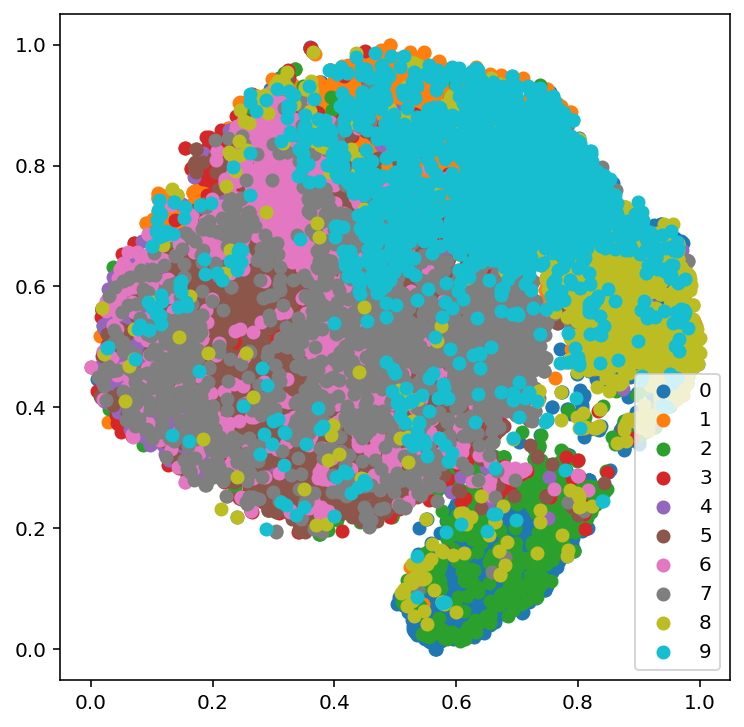

In [20]:
from sklearn.manifold import TSNE


tsne = TSNE()
images_cpu = [im.cpu().numpy().flatten() for im in images_db]
labels_cpu = [l.cpu().numpy().argmax() for l in labels_db]
X_embedded = tsne.fit_transform(np.array(images_cpu), np.array(labels_cpu))

plot_db(X_embedded, labels_cpu)